In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from src import hrNet
from src import readFrames

2023-03-07 11:28:06.785220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 11:28:07.204073: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 11:28:07.316933: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 11:28:08.200792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
patch_tmin1, patch_t, patch_tplus1 = readFrames("KristenAndSara_10frames_512x256.yuv420p",[512,256],1,7)

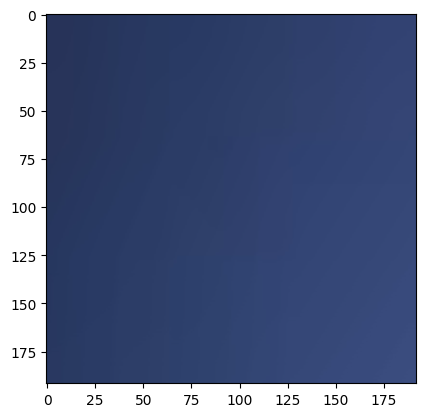

In [3]:
patch_tSmall = patch_t[:192,:192,:]
plt.imshow(patch_tSmall/255.0)

In [9]:
inputPatches = np.concatenate((patch_tSmall,patch_tSmall,patch_tSmall),axis=-1)
inputPatches = np.expand_dims(inputPatches,axis=0)/255.0

In [10]:
hrNetModel = hrNet(2, [32, 64, 128, 256], 5).model()
hrNetModel.load_weights('results/HRNET_MSE.h5')

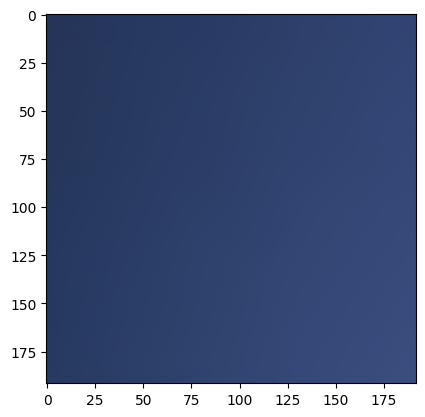

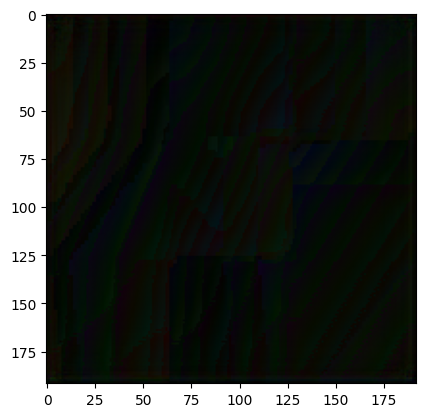

In [17]:
outputPatch = hrNetModel(inputPatches,training=False)
plt.imshow(outputPatch[0])
plt.show()

plt.imshow(np.abs(outputPatch[0] - (patch_tSmall/255.0))*10.0)
plt.show()

In [3]:
from library import readYUV420, YUV2RGB, hrNet
from library.GeneralOps import RGB2YUV, writeYUV420
from src.auxFunctions import deconstruct, reconstruct
import numpy as np
import tensorflow as tf

YUV = readYUV420("dataset/KristenAndSara_10frames_512x256.yuv420p", (512,256), upsampleUV=True)

YUVvideo = np.stack((YUV[0],YUV[1],YUV[2]),axis=-1)
YUVvideo = np.insert(YUVvideo,0,YUVvideo[0,:,:,:],axis=0)
YUVvideo = np.insert(YUVvideo,-1,YUVvideo[YUVvideo.shape[0]-1,:,:,:],axis=0)

# get the nuber of patches for a frame
_testPatch = deconstruct(YUVvideo[0,:,:,:])
numPatches = _testPatch.shape[0]

# get patches from frames at time t, t-1 and t+1
patches_t = np.empty((numPatches *(YUVvideo.shape[0]-2),192,192,3))
patches_tmin1 = np.empty((numPatches *(YUVvideo.shape[0]-2),192,192,3))
patches_tplus1 = np.empty((numPatches *(YUVvideo.shape[0]-2),192,192,3))

# we build patches_t from slicing between the original start and end of array
for _frame in range(1,YUVvideo.shape[0]-1):
    patches_t[(_frame-1) * numPatches : ((_frame-1) * numPatches + numPatches),:,:,:] = deconstruct(YUVvideo[_frame,:,:,:])

# building patches_tmin1
for _frame in range(0,YUVvideo.shape[0]-2):
    patches_tmin1[(_frame) * numPatches : ((_frame) * numPatches + numPatches),:,:,:] = deconstruct(YUVvideo[_frame,:,:,:])

for _frame in range(2,YUVvideo.shape[0]):
    patches_t[(_frame-2) * numPatches : ((_frame-2) * numPatches + numPatches),:,:,:] = deconstruct(YUVvideo[_frame,:,:,:])

# shape is now (N*numFrames) x 192 x192 x 9
inputPatches = np.concatenate((YUV2RGB(patches_tmin1),YUV2RGB(patches_t),YUV2RGB(patches_tplus1)), axis=-1)

# NB: Scale inputs from 0-255 to 0-1 for the new weights
inputPatches = inputPatches/255.0

outputPatches = np.empty((inputPatches.shape[0],192,192,3))
hrNetModel = hrNet(2, [32, 64, 128, 256], 5).model()
hrNetModel.load_weights('results/HRNET_CAMBI_ALPHA1.0.h5')
print(f"GPUS: {tf.config.list_physical_devices('GPU')}")
BATCHSIZE = 4

NUMSTEPS = inputPatches.shape[0] // BATCHSIZE
for _step in range(NUMSTEPS):
    inputPatch = inputPatches[_step * BATCHSIZE: _step * BATCHSIZE + BATCHSIZE,:,:,:]
    outputPatches[_step * BATCHSIZE : _step * BATCHSIZE + BATCHSIZE,:,:,:] = hrNetModel(tf.convert_to_tensor(inputPatch), training=False)

if inputPatches.shape[0] > (BATCHSIZE * NUMSTEPS):
    # Patches left to process
    inputPatch = inputPatches[NUMSTEPS * BATCHSIZE: -1,:,:,:]
    outputPatches[NUMSTEPS * BATCHSIZE: -1,:,:,:] = hrNetModel(tf.convert_to_tensor(inputPatch), training=False)

outputVideoRGB = np.empty((8,256,512,3))
for _frame in range(outputVideoRGB.shape[0]):
    outputVideoRGB[_frame,:,:,:] = reconstruct(outputPatches[_frame * numPatches : _frame * numPatches + numPatches], YUVvideo[0],192)

outputVideoYUV = RGB2YUV(outputVideoRGB)

Yout = outputVideoYUV[:,:,:,0]; Uout = outputVideoYUV[:,:,:,1]; Vout = outputVideoYUV[:,:,:,2]; 
writeYUV420("output/"+"restored_video.yuv",np.uint8(Yout),np.uint8(Uout),np.uint8(Vout),downsample=True)

GPUS: []


KeyboardInterrupt: 

In [4]:

from library import readYUV420, YUV2RGB, hrNet
from library.GeneralOps import RGB2YUV, writeYUV420, readYUV2RGB
from src.auxFunctions import deconstruct, reconstruct
import numpy as np
import tensorflow as tf
import os
import time

# Testing for 1080p Video
# baseCompPath = '/data/nwaliv/trainVideoSetDeg/'
# vidName = "DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_4_AV1_CRF38_.yuv"
# _comp = os.path.join(baseCompPath,vidName)
# _width = 1920
# _height = 1080
# _numFrames = 120
# outVidName = "output/res_Dolby.yuv"
# modelWeights = "results/HRNET_CAMBI_ALPHA1.0.h5"
# BATCHSIZE = 16

seconds = time.time()
# Works for 480p video
baseCompPath = '/data/nwaliv/trainVideoSetDeg/'
vidName = "DCloudsStaticBVITexture_480x272_120fps_10bit_420_H264_CRF31_.yuv"
_comp = os.path.join(baseCompPath,vidName)
_width = 480
_height = 272
_numFrames = 64
outVidName = "output/res_Dbro.yuv"
modelWeights = "results/HRNET_CAMBI_ALPHA1.0.h5"
BATCHSIZE = 16



# baseCompPath = 'dataset/'
# vidName = "KristenAndSara_10frames_512x256.yuv420p"
# _comp = os.path.join(baseCompPath,vidName)
# _width = 512
# _height = 256
# _numFrames = 8
# outVidName = "output/res_Krissy.yuv"
# modelWeights = "results/HRNET_CAMBI_ALPHA1.0.h5"
# BATCHSIZE = 16


RGBvideo = readYUV2RGB(_comp,(_width,_height))
#YUVvideo = np.stack((YUV[0],YUV[1],YUV[2]),axis=-1)
RGBvideo = np.insert(RGBvideo,0,RGBvideo[0,:,:,:],axis=0)
RGBvideo = np.insert(RGBvideo,-1,RGBvideo[RGBvideo.shape[0]-1,:,:,:],axis=0)

# get the number of patches for a frame
_testPatch = deconstruct(RGBvideo[0,:,:,:])
numPatches = _testPatch.shape[0]

print(numPatches)

# get patches from frames at time t, t-1 and t+1
patches_t = np.empty((numPatches *(RGBvideo.shape[0]-2),192,192,3))
patches_tmin1 = np.empty((numPatches *(RGBvideo.shape[0]-2),192,192,3))
patches_tplus1 = np.empty((numPatches *(RGBvideo.shape[0]-2),192,192,3))

# we build patches_t from slicing between the original start and end of array
for _frame in range(1,RGBvideo.shape[0]-1):
    patches_t[(_frame-1) * numPatches : ((_frame-1) * numPatches + numPatches),:,:,:] = deconstruct(RGBvideo[_frame,:,:,:])

# building patches_tmin1
for _frame in range(0,RGBvideo.shape[0]-2):
    patches_tmin1[(_frame) * numPatches : ((_frame) * numPatches + numPatches),:,:,:] = deconstruct(RGBvideo[_frame,:,:,:])

for _frame in range(2,RGBvideo.shape[0]):
    patches_t[(_frame-2) * numPatches : ((_frame-2) * numPatches + numPatches),:,:,:] = deconstruct(RGBvideo[_frame,:,:,:])



# shape is now (N*numFrames) x 192 x192 x 9 where N is the number of patches obtained from deconstruct
inputPatches = np.concatenate((patches_tmin1,patches_t,patches_tplus1), axis=-1)

print(_comp)

# NB: Scale inputs from 0-255 to 0-1 for the new weights
inputPatches = inputPatches/255.0

outputPatches = np.empty((inputPatches.shape[0],192,192,3))
hrNetModel = hrNet(2, [32, 64, 128, 256], 5).model()
hrNetModel.load_weights(modelWeights)

print(f"GPUS: {tf.config.list_physical_devices('GPU')}")
print(_comp)


NUMSTEPS = inputPatches.shape[0] // BATCHSIZE
for _step in range(NUMSTEPS):
    inputPatch = inputPatches[_step * BATCHSIZE: _step * BATCHSIZE + BATCHSIZE,:,:,:]
    outputPatches[_step * BATCHSIZE : _step * BATCHSIZE + BATCHSIZE,:,:,:] = hrNetModel(tf.convert_to_tensor(inputPatch), training=False)

if inputPatches.shape[0] > (BATCHSIZE * NUMSTEPS):
    # Patches left to process
    inputPatch = inputPatches[NUMSTEPS * BATCHSIZE: -1,:,:,:]
    outputPatches[NUMSTEPS * BATCHSIZE: -1,:,:,:] = hrNetModel(tf.convert_to_tensor(inputPatch), training=False)

outputVideoRGB = np.empty((_numFrames,_height,_width,3))
for _frame in range(outputVideoRGB.shape[0]):
    outputVideoRGB[_frame,:,:,:] = reconstruct(outputPatches[_frame * numPatches : _frame * numPatches + numPatches], RGBvideo[0],192)

outputVideoYUV = RGB2YUV(outputVideoRGB)

outputVideoYUV = outputVideoYUV * 255.0

Yout = outputVideoYUV[:,:,:,0]; Uout = outputVideoYUV[:,:,:,1]; Vout = outputVideoYUV[:,:,:,2]; 
writeYUV420(outVidName,np.uint8(Yout),np.uint8(Uout),np.uint8(Vout),downsample=True)
seconds_2 = time.time()
print("Time taken =", seconds_2 - seconds)